##### Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# fix random seed for reproducibility
np.random.seed(7)

# Notebook

The folder time_series contains a list of files. Each file contains all the time series associated with a given product. Each time series corresponds to a company.

There are two types of files:

**- Wide**: each column corresponds to the time series of a company.

**- Long**: the information is stored in long format. The column company identifies the company, the colum timestamp the instant at which a price was recorded, and the column price the value of the price. These dataframes contain some other columns whose meaning will be explained next.

On the title of each file the Product Group (a product group corresponds to a group of time series of the same product sold by different companies) is identified by a number, called the product_group_id.

The file 'product_information' contains information about the products in each product group. This file contains the following columns:

- **offer_type** - offer type associated with that time series. A product can be locked, unlocked... to a certain operator.
- **product** - name of the product associated with time series
- **product_group_id** - uniquely identifies a product group. A product group is uniquely identified by its name and its offer_type.

**Example**: read a file and its product_information

In [2]:
# Select product_group_id
product_group_id = 958
# Read file
df = pd.read_pickle("Data/time_series_1/long_product_group_id_" + str(product_group_id))
df

,product_id,timestamp,product,country,company,product_group_id,offer_type,price
422267,3217,2020-06-21,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422268,3217,2020-06-22,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422269,3217,2020-06-23,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422270,3217,2020-06-24,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
422271,3217,2020-06-25,huawei Y9S 128GB,CL,movistar,958,unlocked,272.891840
...,...,...,...,...,...,...,...,...
426112,3230,2021-03-18,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426113,3230,2021-03-19,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426114,3230,2021-03-20,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955
426115,3230,2021-03-21,huawei Y9S 128GB,CL,Lider,958,unlocked,209.214955


In [3]:
# Read product information of the time series of that product group
product_information = pd.read_pickle("Data/product_information")
product_information

,product,offer_type
product_group_id,,
1,xiaomi Pocophone 128GB,unlocked
2,xiaomi Redmi Note 8 128GB,unlocked
5,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 6,unlocked
6,xiaomi Redmi Note 9 Pro 64GB + AIWA AW 8,unlocked
7,blu Joy Adulto Mayor Sos,unlocked
...,...,...
952,huawei P30 128GB + P Smart 2019,unlocked
953,motorola Moto G7 Power 64GB,unlocked
956,nokia 6.1 32GB,unlocked


In [4]:
def get_product_wide(product_group_id, time_series='1'):
    return pd.read_pickle(f"Data/time_series_{time_series}/wide_product_group_id_{product_group_id}")

# Data Visualization

In [5]:
plt.rcParams['figure.dpi'] = 100
product_group_id = 958
time_series = '1'

df_wide = get_product_wide(product_group_id, time_series=time_series)
df_wide = df_wide.drop(["vtr", "macOnline"], axis=1)
print("Number of daily data: ", len(df_wide))

Number of daily data:  507


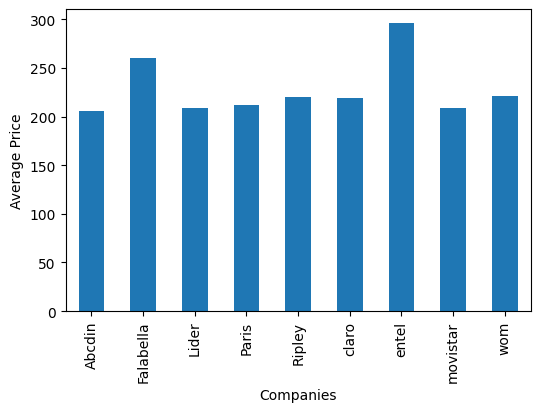

In [6]:
plt.ylabel("Average Price")
plt.xlabel("Companies")
df_wide.mean().plot(kind='bar')
plt.show()

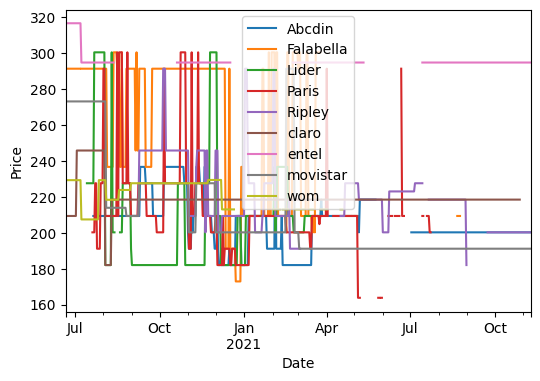

In [7]:
df_wide.plot()
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

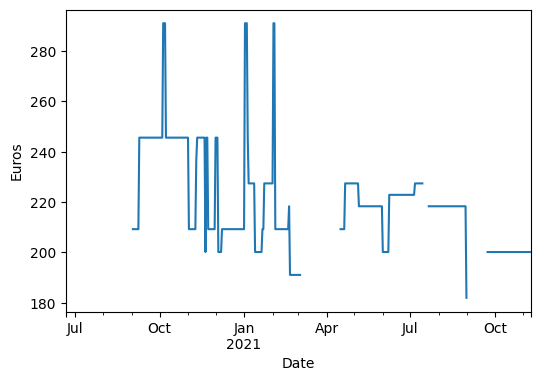

In [8]:
df_wide["Ripley"].plot()
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

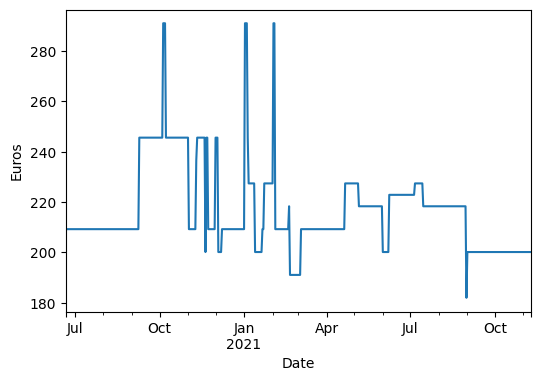

In [9]:
df_wide["Ripley"].fillna(method='bfill', inplace=True)
df_wide["Ripley"].fillna(method='ffill', inplace=True)
df_wide["Ripley"].plot()
# plt.title(f"Ripley's price variation over time for product group id {product_group_id}")
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

Abcdin 507
Falabella 507
Lider 507
Paris 507
Ripley 507
claro 507
entel 507
movistar 507
wom 507


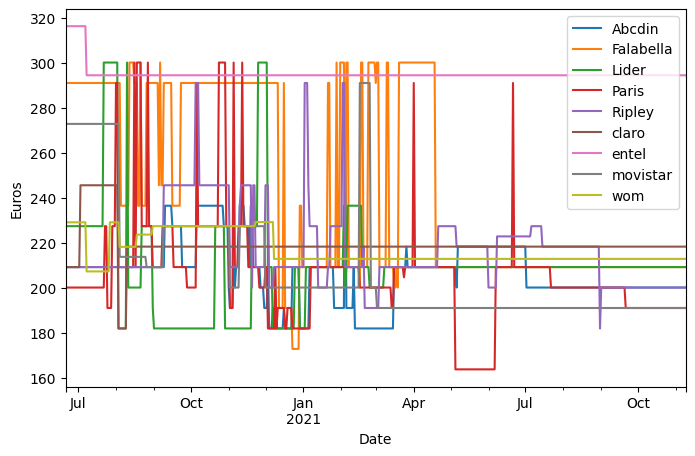

In [29]:
for comp in df_wide.keys():
    df_wide[comp].fillna(method='ffill', inplace=True)
    df_wide[comp].fillna(method='bfill', inplace=True)
    print(comp, len(df_wide[comp]))
df_wide.plot()
# plt.title(f"Companies price variation over time for product group id {product_group_id}")
plt.ylabel('Euros')
plt.xlabel('Date')
plt.show()

## Signal Decomposition

### Multiplicative Model

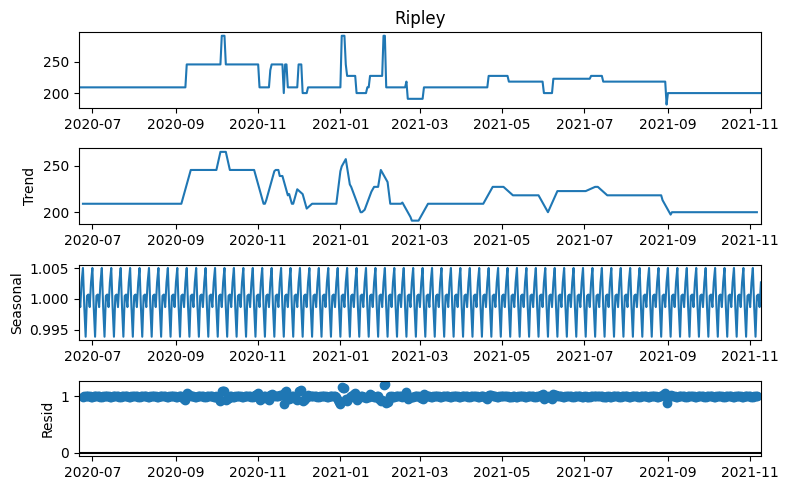

In [26]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
components = seasonal_decompose(df_wide["Ripley"], model='multiplicative', period=7)
components.plot()
plt.show()

### Additive Model

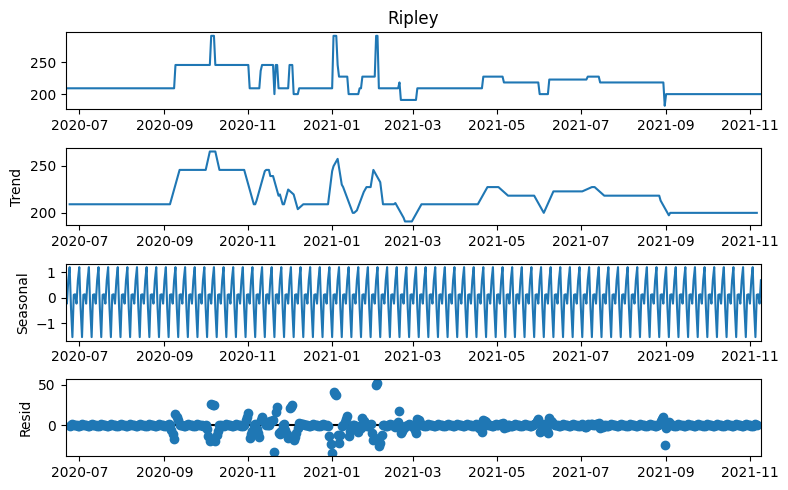

In [30]:
components = seasonal_decompose(df_wide["Ripley"], model='additive', period=7)
components.plot()
plt.show()

In [27]:
product_group_id = 958
time_series = '1'
company = "Ripley"
n_steps = 8 # number of days
train_split_amount = 0.7

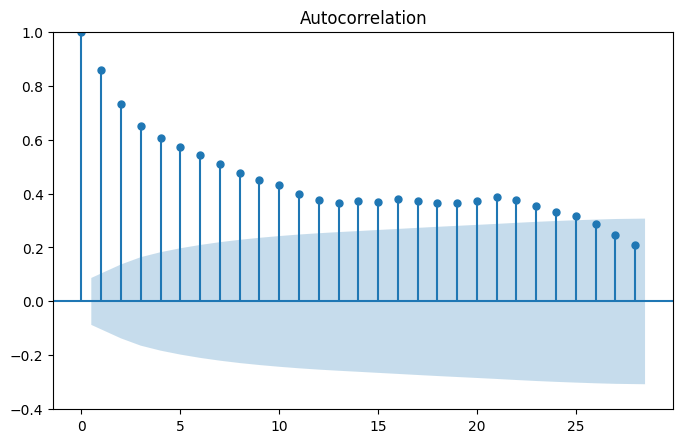

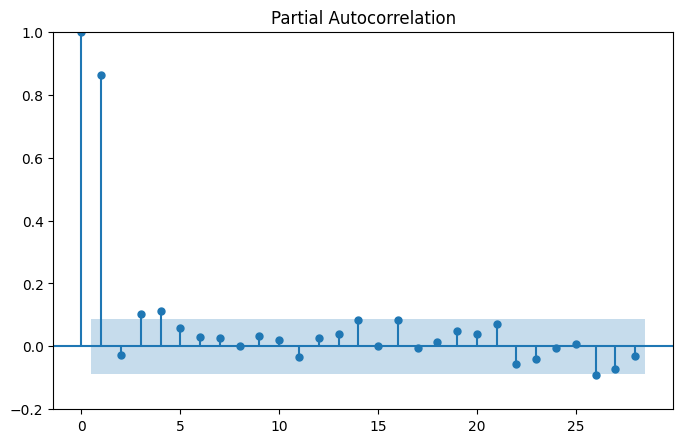

In [28]:
plot_acf(df_wide[company])
plt.ylim(-0.4)
plot_pacf(df_wide[company])
plt.ylim(-0.2)
plt.show()

In [13]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df_wide[company])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.538491168697959
p-value: 0.00016743668356527359


Since the p-value is less than 0.05 we reject the null hypothesis with a high probability.
Meaning that data is stationary.

# Define Evaluation metrics

In [4]:
product_group_id = 958
time_series = '1'
company = "Ripley"
n_steps = 8 # number of days
train_split_amount = 0.7

def evaluate_pred(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    rmse = str(round(np.sqrt(mse), 4))
    rmsle = str(round(np.log(np.sqrt(mse)), 4))
    mse = str(round(mse, 4))
    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]
    k = X_test.shape[1]
    adjusted_r2 = str(round(1 - ((1-r2) * ((n-1)/(n-k-1))), 4))
    r2 = str(round(r2, 4))

    table = [
        ["Mean Absolute Error (MAE)", mae],
        ["Mean Squared Error (MSE)", mse],
        ["Root Mean Squared Error (RMSE)", rmse],
        ["Root Mean Squared Log Error (RMSLE)", rmsle],
        ["R Squared (R2)", r2],
        ["Adjusted R Squared (AR2)", adjusted_r2],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    fig = plt.figure(figsize=(6, 4), dpi=200)
    plt.plot(y_test, color='b', label='real data')
    plt.plot(y_pred, color='r', label='predictions on test data')
    plt.title("Product Price Prediction")
    plt.xlabel('samples')
    plt.legend()
    plt.show()

    return [x[1] for x in table]

# Define Evaluation Strategy

In [17]:
n_epochs = 50
verbose = 0

# define evaluation strategy
def train_and_test_model(model, n_epochs=50, verbose=0):
    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=n_epochs, verbose=verbose)

    # get predictions on test data
    y_pred = model.predict(X_test, verbose=verbose)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss function')
    plt.legend(['train', 'test'])
    plt.xlabel('iterations')

    return y_pred

# Univariate Models

## Get Train and Test Data

In [15]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train = np.empty(shape=[0, n_steps], dtype=np.float32)
y_train = np.array([], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps], dtype=np.float32)
y_test = np.array([], dtype=np.float32)

df_wide = get_product_wide(product_group_id, time_series)
if company in df_wide.keys():
    # DROP NAN VALUES
    df_wide[company].fillna(method='bfill', inplace=True)
    df_wide[company].fillna(method='ffill', inplace=True)
    prices = df_wide[company].values

    # SPLIT THE TIME SERIES OF PRICES INTO SEVERAL SHORT SEQUENCES
    X, y = split_sequence(prices, n_steps)

    # SPLIT INTO TRAIN AND TEST DATA
    train_size = int(len(y) * train_split_amount)
    test_size = len(y) - train_size

    # ADD DATA TO DATASET
    X_train = np.concatenate((X_train, X[0:train_size,:]))
    y_train = np.append(y_train, y[0:train_size])
    X_test = np.concatenate((X_test, X[train_size:,:]))
    y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(349, 8)
(349,)
(150, 8)
(150,)


## Normalizing Data

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and apply the scaler on the TRAINING data
X_train = scaler.fit_transform(X_train)

# apply scaler on the TEST data
X_test = scaler.transform(X_test)

In [17]:
# We are working with a univariate series, so the number of features is one, for one variable.
n_features = 1
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print(X_train.shape)
print(X_test.shape)

univariate_results = []

(349, 8, 1)
(150, 8, 1)


## ARIMA

In [19]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm(order_list):
        try:
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            print(f"{order} is not possible")
            continue
    
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [20]:
## Set the grid search parameters
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df_wide[company][:train_size])

result_df

100%|██████████| 64/64 [00:19<00:00,  3.35it/s]


,"(p, d, q)",AIC
0,"(1, 1, 2)",2608.889077
1,"(2, 1, 1)",2608.995932
2,"(3, 1, 1)",2610.730906
3,"(1, 1, 3)",2610.831838
4,"(2, 1, 2)",2610.867835
...,...,...
59,"(7, 1, 6)",2623.850395
60,"(2, 1, 0)",2629.408712
61,"(0, 1, 0)",2636.016885
62,"(0, 1, 1)",2637.484704


In [21]:
best_order = result_df[result_df.AIC == result_df.AIC.min()]["(p, d, q)"].values[0]
best_order

(1, 1, 2)

                               SARIMAX Results                                
Dep. Variable:                 Ripley   No. Observations:                  349
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1300.445
Date:                Mon, 09 Jan 2023   AIC                           2608.889
Time:                        17:09:11   BIC                           2624.298
Sample:                    06-21-2020   HQIC                          2615.024
                         - 06-04-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6286      0.065      9.690      0.000       0.501       0.756
ma.L1         -0.7464      0.074    -10.135      0.000      -0.891      -0.602
ma.L2         -0.1547      0.046     -3.356      0.0

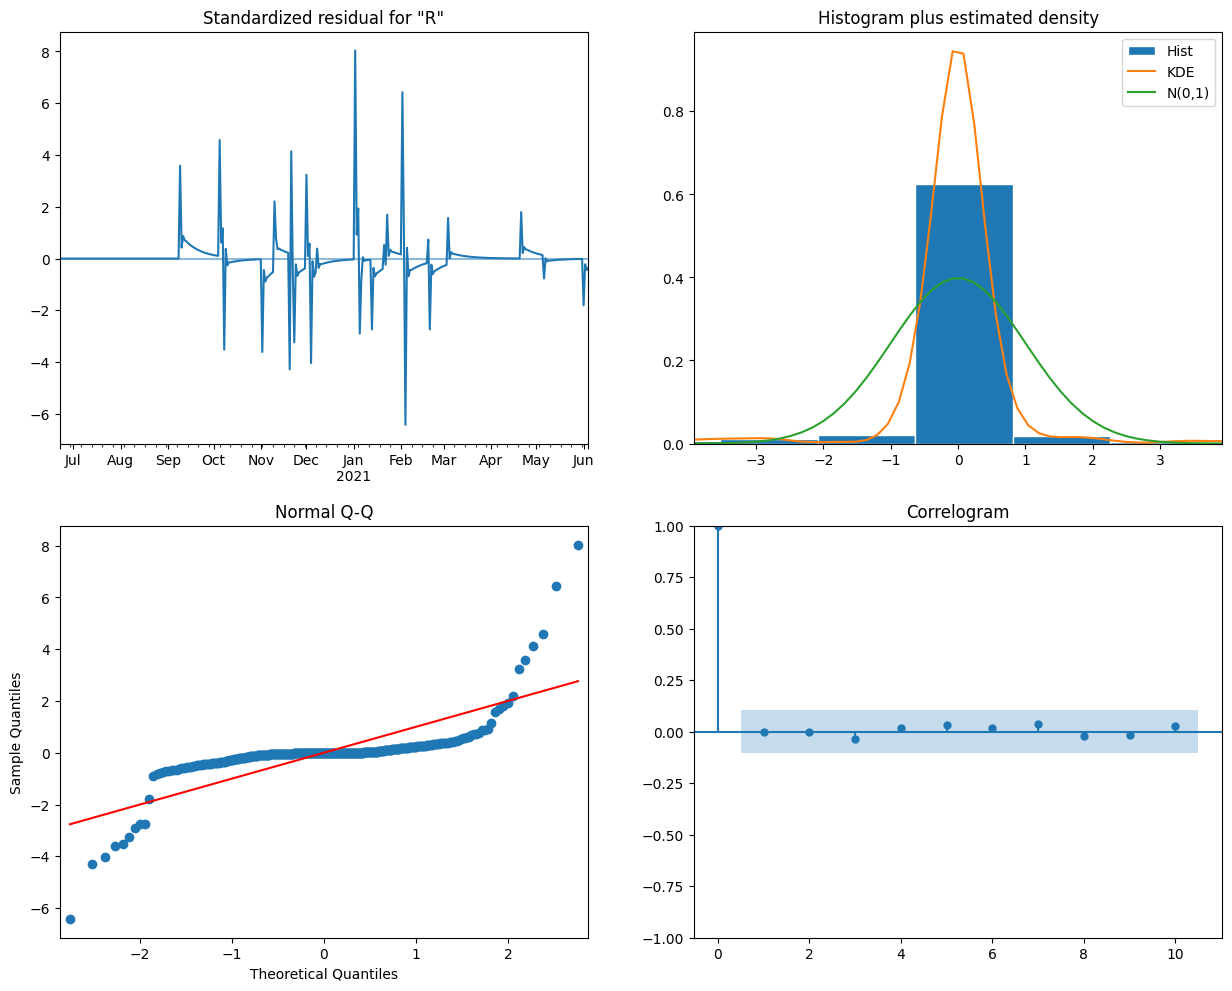

In [22]:
best_model = SARIMAX(df_wide[company][:train_size], order=best_order).fit()
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [23]:
## Use the model to predict the next values in the time series

# Here we construct a more complete results object.
NN = len(df_wide[company]) - train_size
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print("Statistics of confidence intervals")
fcast.summary_frame(alpha=0.05)

Forcast on 158 next values
2021-06-05    203.587480
2021-06-06    206.342688
2021-06-07    208.074490
2021-06-08    209.163024
2021-06-09    209.847229
                 ...    
2021-11-05    211.005038
2021-11-06    211.005038
2021-11-07    211.005038
2021-11-08    211.005038
2021-11-09    211.005038
Freq: D, Name: predicted_mean, Length: 158, dtype: float64
Statistics of confidence intervals


Ripley,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-06-05,203.587480,10.147026,183.699675,223.475285
2021-06-06,206.342688,13.531178,179.822067,232.863308
2021-06-07,208.074490,15.068143,178.541473,237.607507
2021-06-08,209.163024,15.930623,177.939577,240.386472
2021-06-09,209.847229,16.488677,177.530016,242.164443
...,...,...,...,...
2021-11-05,211.005038,37.079530,138.330496,283.679581
2021-11-06,211.005038,37.177796,138.137898,283.872179
2021-11-07,211.005038,37.275803,137.945807,284.064270
2021-11-08,211.005038,37.373553,137.754220,284.255857



Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             10.3591
Mean Squared Error (MSE)             115.477
Root Mean Squared Error (RMSE)        10.746
Root Mean Squared Log Error (RMSLE)    2.3745
R Squared (R2)                         0.0064
Adjusted R Squared (AR2)              -0.0499


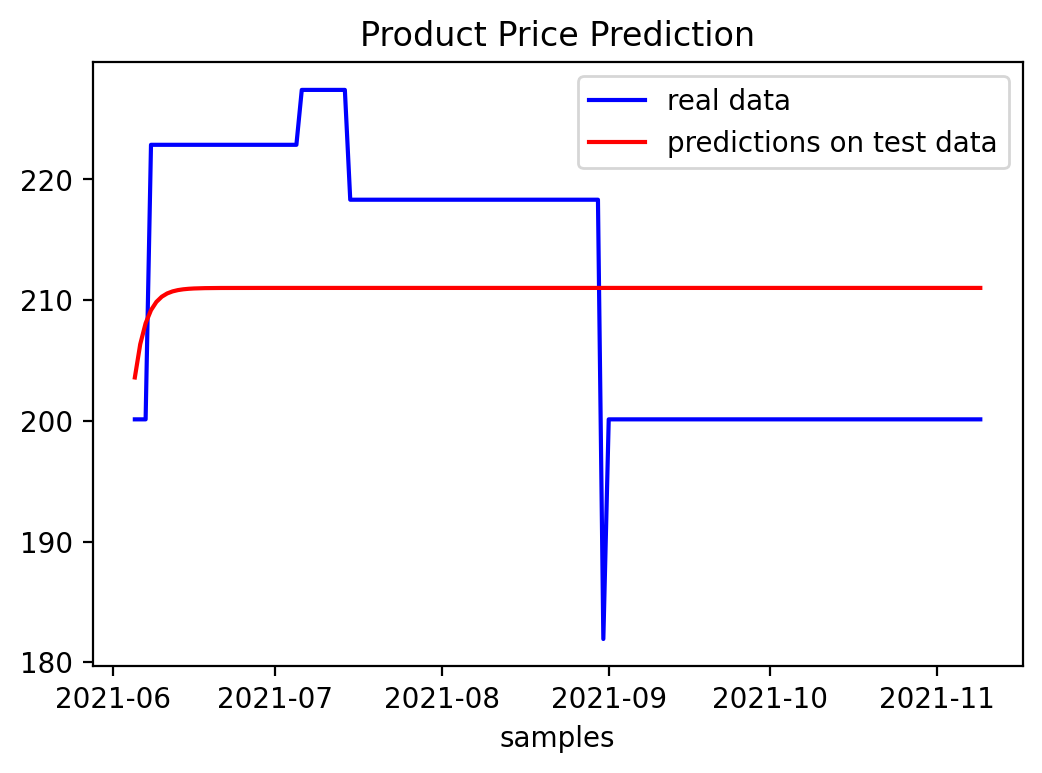

In [24]:
# evaluate the model predictions
y_pred = fcast.summary_frame(alpha=0.05)["mean"]
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "ARIMA")
univariate_results.append(metrics)

## SARIMA

In [25]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            print(f"{order} is not possible")
            continue
        results.append([param, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [26]:
## SARIMA grid of hyperparameters
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 7 # a season was considered to be a week

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, d, D, s, df_wide[company][:train_size])
result_df

256


100%|██████████| 256/256 [05:12<00:00,  1.22s/it]


,"(p,q)x(P,Q)",AIC
0,"(1, 2, 3, 3)",2579.280258
1,"(2, 1, 3, 3)",2579.508307
2,"(3, 1, 3, 3)",2581.015765
3,"(2, 2, 3, 3)",2581.270353
4,"(1, 3, 3, 3)",2581.343768
...,...,...
251,"(0, 2, 0, 0)",2811.173286
252,"(2, 0, 0, 0)",2812.228362
253,"(0, 0, 0, 0)",2817.637730
254,"(0, 1, 0, 0)",2819.521857


In [27]:
# Choose the values that minimize the AIC score
best_values = result_df[result_df.AIC == result_df.AIC.min()]["(p,q)x(P,Q)"].values[0]
best_order = (best_values[0], d, best_values[1])
print(best_order)
best_seasonal_order = (best_values[2], D, best_values[3], s)
print(best_seasonal_order)

(1, 1, 2)
(3, 1, 3, 7)


                                         SARIMAX Results                                         
Dep. Variable:                                    Ripley   No. Observations:                  349
Model:             SARIMAX(1, 1, 2)x(3, 1, [1, 2, 3], 7)   Log Likelihood               -1279.640
Date:                                   Mon, 09 Jan 2023   AIC                           2579.280
Time:                                           17:14:27   BIC                           2617.599
Sample:                                       06-21-2020   HQIC                          2594.547
                                            - 06-04-2021                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6941      0.056     12.492      0.000    

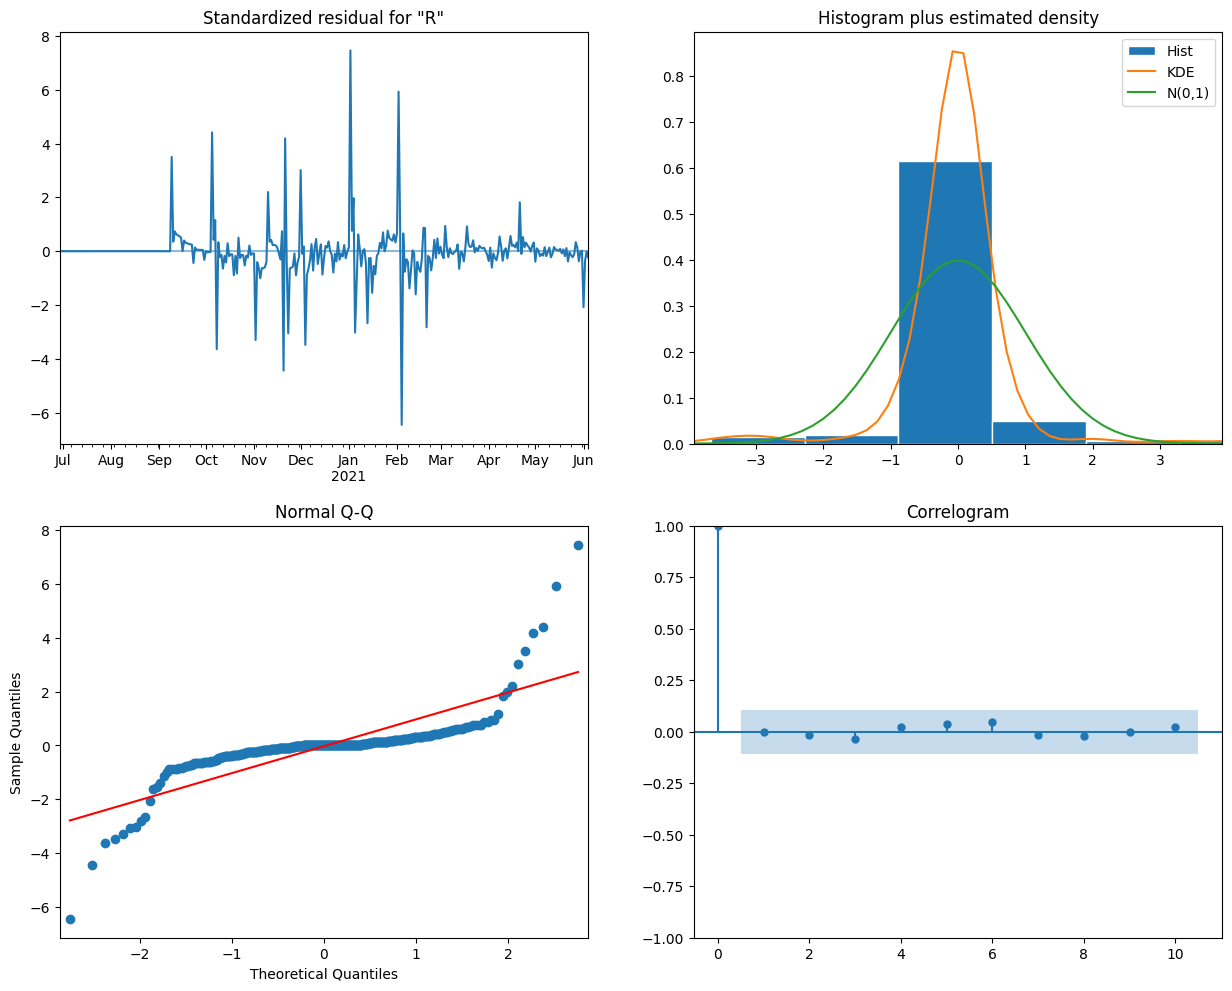

In [28]:
best_model = SARIMAX(df_wide[company][:train_size], order=best_order, seasonal_order=best_seasonal_order).fit(dis=-1)
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [29]:
## Use the model to predict the next values in the time series

# Here we construct a more complete results object.
NN = len(df_wide[company]) - train_size
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print("Statistics of confidence intervals")
fcast.summary_frame(alpha=0.05)

Forcast on 158 next values
2021-06-05    202.956320
2021-06-06    205.234119
2021-06-07    205.324722
2021-06-08    206.518021
2021-06-09    207.450561
                 ...    
2021-11-05    209.865250
2021-11-06    212.165776
2021-11-07    212.205018
2021-11-08    211.777914
2021-11-09    212.788027
Freq: D, Name: predicted_mean, Length: 158, dtype: float64
Statistics of confidence intervals


Ripley,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-06-05,202.956320,9.947740,183.459107,222.453533
2021-06-06,205.234119,13.357963,179.052994,231.415245
2021-06-07,205.324722,15.032591,175.861386,234.788058
2021-06-08,206.518021,16.005245,175.148316,237.887725
2021-06-09,207.450561,16.631818,174.852797,240.048325
...,...,...,...,...
2021-11-05,209.865250,44.937713,121.788951,297.941549
2021-11-06,212.165776,45.104286,123.762999,300.568553
2021-11-07,212.205018,45.269576,123.478278,300.931757
2021-11-08,211.777914,45.425258,122.746043,300.809784



Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             10.5941
Mean Squared Error (MSE)             124.027
Root Mean Squared Error (RMSE)        11.1368
Root Mean Squared Log Error (RMSLE)    2.4103
R Squared (R2)                        -0.0671
Adjusted R Squared (AR2)              -0.1277


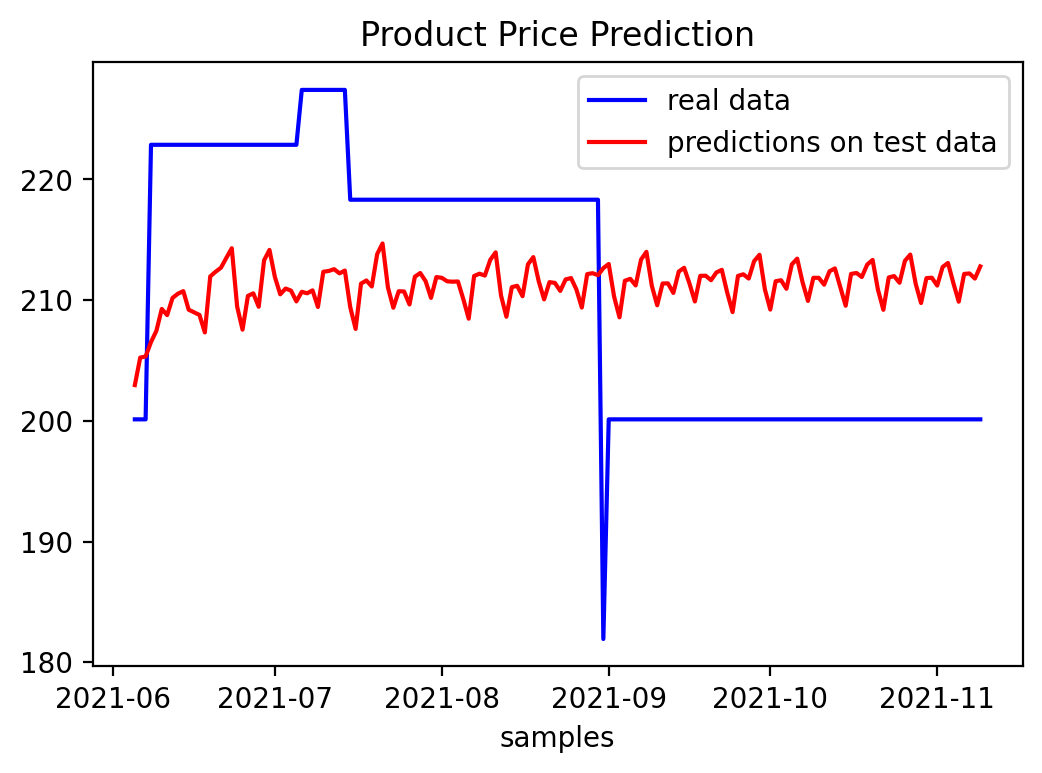

In [30]:
# evaluate the model predictions
y_pred = fcast.summary_frame(alpha=0.05)["mean"]
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "SARIMA")
univariate_results.append(metrics)

## Vanilla LSTM

In [31]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


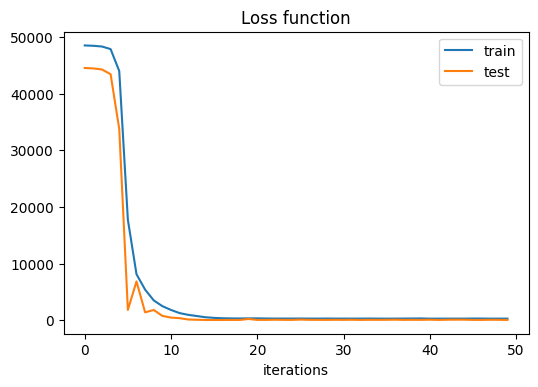

In [32]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             5.2046
Mean Squared Error (MSE)             38.2423
Root Mean Squared Error (RMSE)        6.184
Root Mean Squared Log Error (RMSLE)   1.822
R Squared (R2)                        0.6684
Adjusted R Squared (AR2)              0.6496


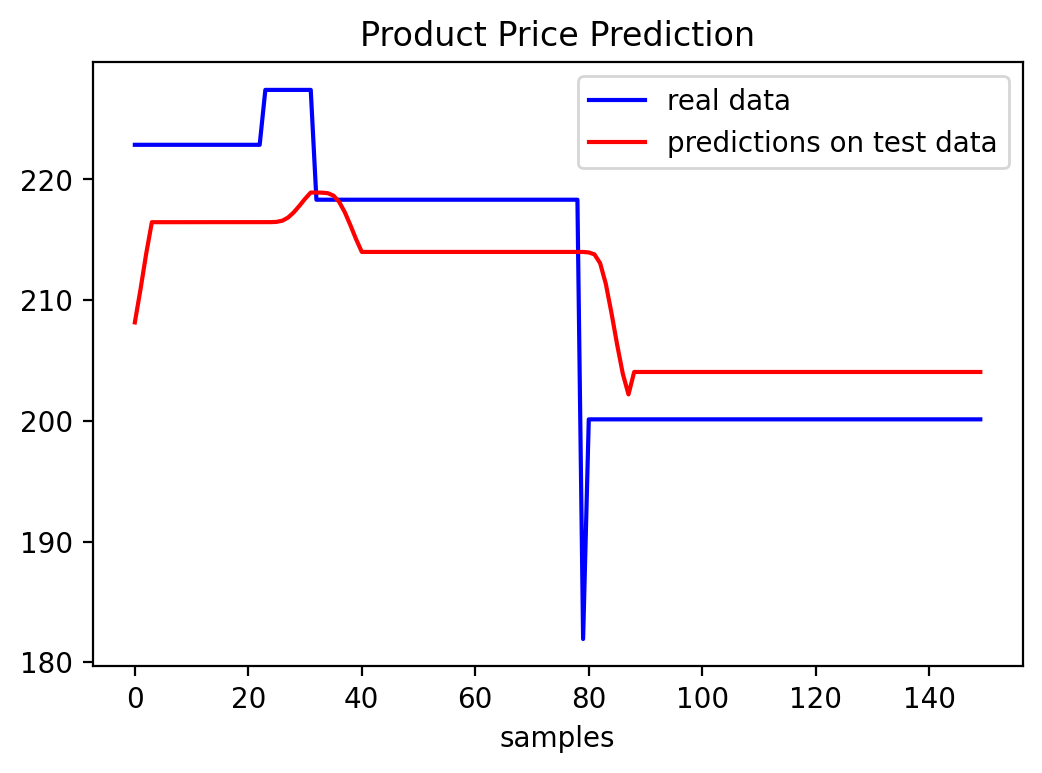

In [33]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Vanilla LSTM")
univariate_results.append(metrics)

## Stacked LSTM

In [34]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8, 50)             10400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


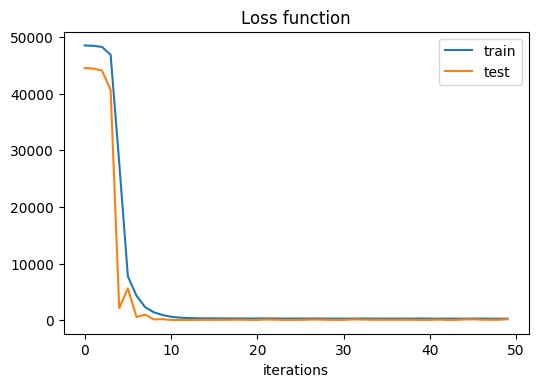

In [35]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             11.2565
Mean Squared Error (MSE)             158.024
Root Mean Squared Error (RMSE)        12.5708
Root Mean Squared Log Error (RMSLE)    2.5314
R Squared (R2)                        -0.3701
Adjusted R Squared (AR2)              -0.4479


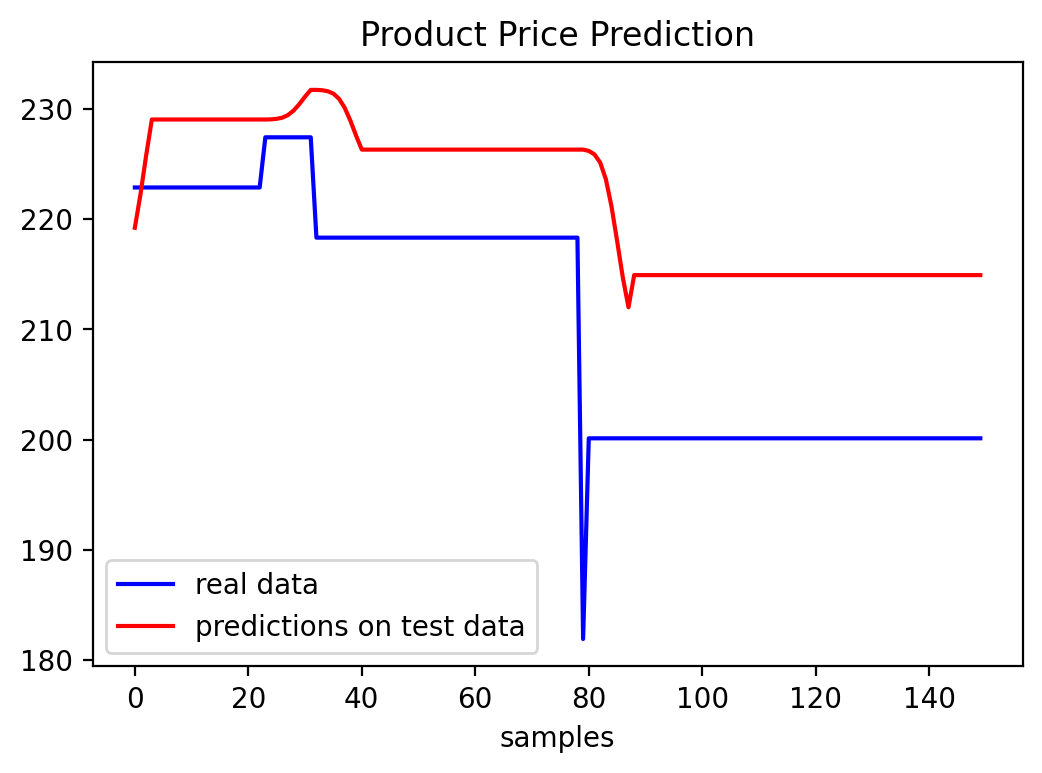

In [36]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Stacked LSTM")
univariate_results.append(metrics)

## Bidirectional LSTM

In [37]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

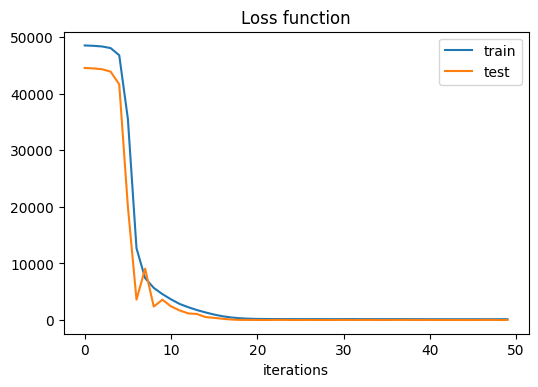

In [38]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             3.4119
Mean Squared Error (MSE)             20.5768
Root Mean Squared Error (RMSE)        4.5362
Root Mean Squared Log Error (RMSLE)   1.5121
R Squared (R2)                        0.8216
Adjusted R Squared (AR2)              0.8115


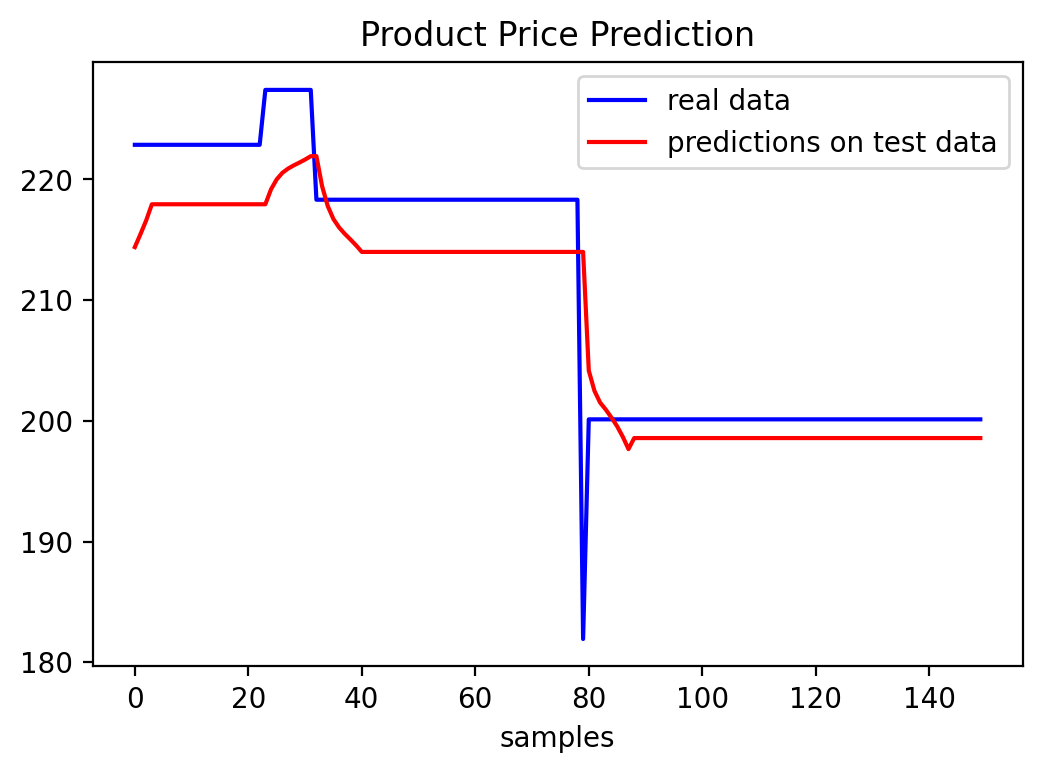

In [39]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Bidirectional LSTM")
univariate_results.append(metrics)

## CNN LSTM

In [40]:
# reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_sub_steps = 4
X_train = X_train.reshape((X_train.shape[0], n_seq, n_sub_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_sub_steps, n_features))
print(X_train.shape)
print(X_test.shape)


(349, 2, 4, 1)
(150, 2, 4, 1)


In [41]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_sub_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

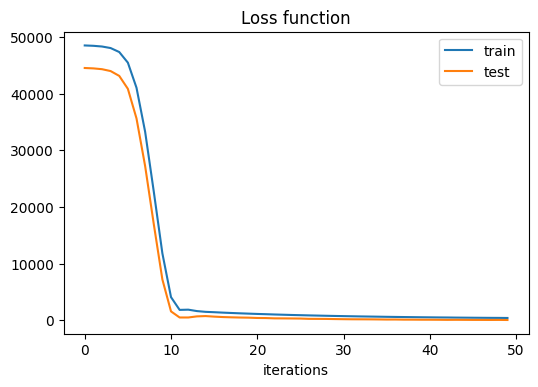

In [42]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             4.1527
Mean Squared Error (MSE)             33.5191
Root Mean Squared Error (RMSE)        5.7896
Root Mean Squared Log Error (RMSLE)   1.7561
R Squared (R2)                        0.7094
Adjusted R Squared (AR2)              0.7054


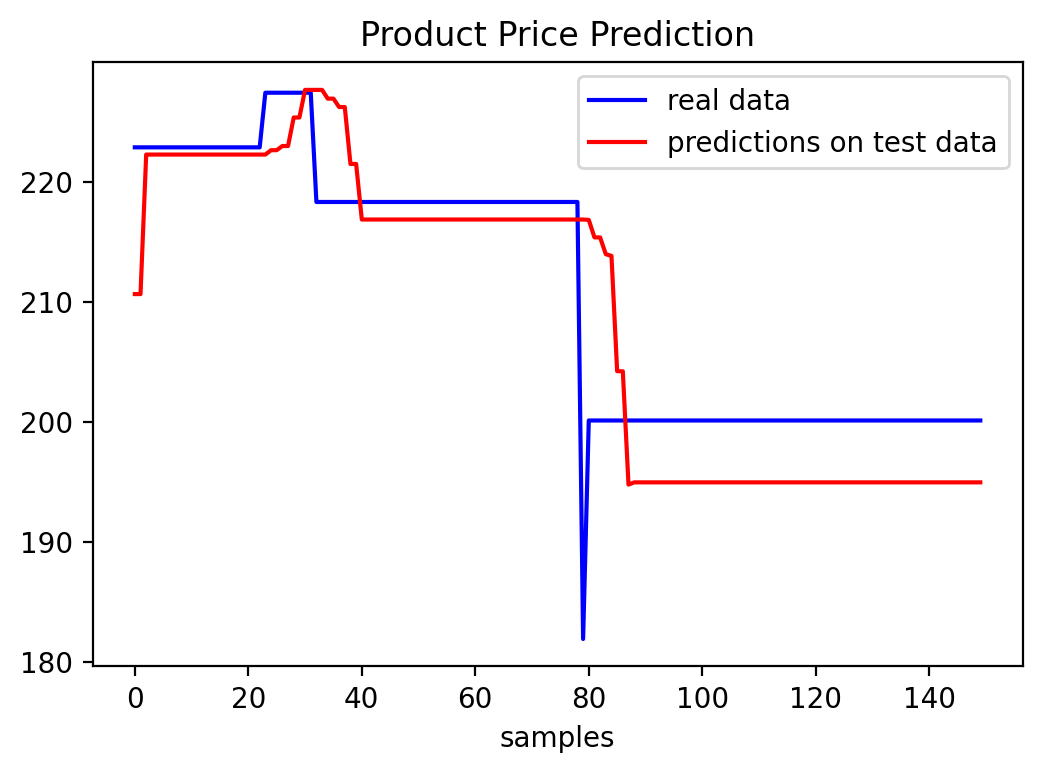

In [43]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "CNN LSTM")
univariate_results.append(metrics)

## ConvLSTM

In [44]:
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_sub_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_sub_steps, n_features))
print(X_train.shape)
print(X_test.shape)

(349, 2, 1, 4, 1)
(150, 2, 1, 4, 1)


In [45]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_sub_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

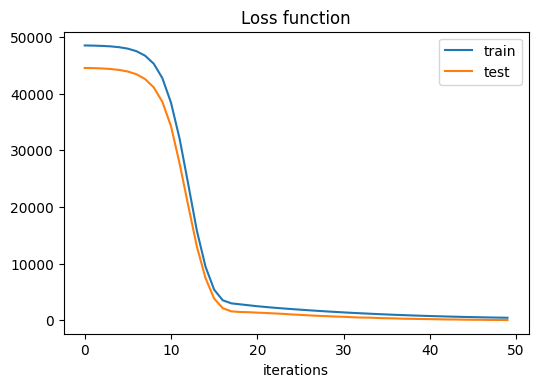

In [46]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             6.237
Mean Squared Error (MSE)             60.9978
Root Mean Squared Error (RMSE)        7.8101
Root Mean Squared Log Error (RMSLE)   2.0554
R Squared (R2)                        0.4711
Adjusted R Squared (AR2)              0.4639


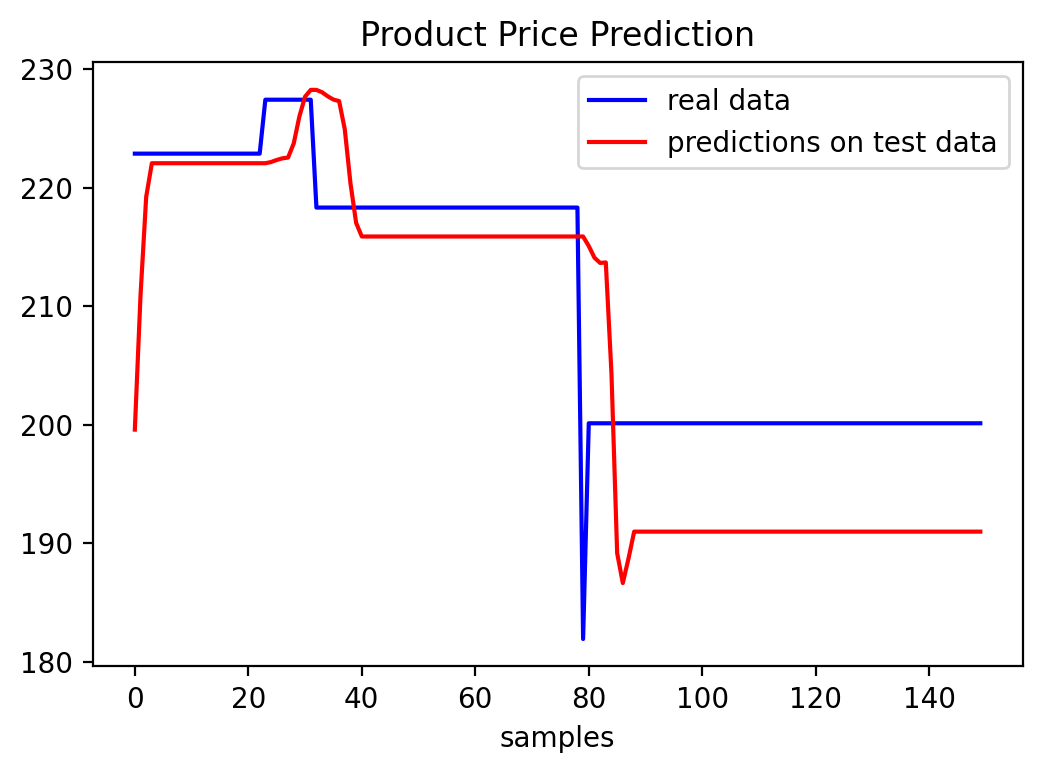

In [47]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "ConvLSTM")
univariate_results.append(metrics)

## Models Results

In [48]:
print(tabulate(univariate_results,
               headers=["Univariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='latex_booktabs'
               ))

tabulate(univariate_results,
         headers=["Univariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='html'
         )

\begin{tabular}{lrrrrrr}
\toprule
 Univariate Model   &     MAE &      MSE &    RMSE &   RMSLE &      R2 &     AR2 \\
\midrule
 ARIMA              & 10.3591 & 115.477  & 10.746  &  2.3745 &  0.0064 & -0.0499 \\
 SARIMA             & 10.5941 & 124.027  & 11.1368 &  2.4103 & -0.0671 & -0.1277 \\
 Vanilla LSTM       &  5.2046 &  38.2423 &  6.184  &  1.822  &  0.6684 &  0.6496 \\
 Stacked LSTM       & 11.2565 & 158.024  & 12.5708 &  2.5314 & -0.3701 & -0.4479 \\
 Bidirectional LSTM &  3.4119 &  20.5768 &  4.5362 &  1.5121 &  0.8216 &  0.8115 \\
 CNN LSTM           &  4.1527 &  33.5191 &  5.7896 &  1.7561 &  0.7094 &  0.7054 \\
 ConvLSTM           &  6.237  &  60.9978 &  7.8101 &  2.0554 &  0.4711 &  0.4639 \\
\bottomrule
\end{tabular}


Univariate Model,MAE,MSE,RMSE,RMSLE,R2,AR2
ARIMA,10.3591,115.477,10.746,2.3745,0.0064,-0.0499
SARIMA,10.5941,124.027,11.1368,2.4103,-0.0671,-0.1277
Vanilla LSTM,5.2046,38.2423,6.184,1.822,0.6684,0.6496
Stacked LSTM,11.2565,158.024,12.5708,2.5314,-0.3701,-0.4479
Bidirectional LSTM,3.4119,20.5768,4.5362,1.5121,0.8216,0.8115
CNN LSTM,4.1527,33.5191,5.7896,1.7561,0.7094,0.7054
ConvLSTM,6.237,60.9978,7.8101,2.0554,0.4711,0.4639


# Multivariate Models

## Get Train and Test Data

Abcdin 507
Falabella 507
Lider 507
Paris 507
Ripley 507
claro 507
entel 507
movistar 507
wom 507


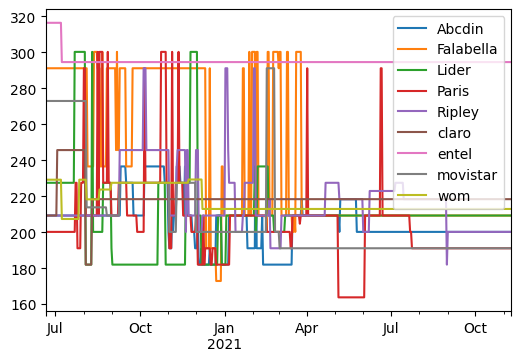

In [5]:
df_wide = get_product_wide(product_group_id, time_series)
df_wide = df_wide.drop(["vtr", "macOnline"], axis=1)
for comp in df_wide.keys():
    df_wide[comp].fillna(method='bfill', inplace=True)
    df_wide[comp].fillna(method='ffill', inplace=True)
    print(comp, len(df_wide[comp]))
df_wide.plot()
n_days = len(df_wide)
n_companies = len(df_wide.keys())
company = "Ripley"

In [6]:
X_train = np.empty(shape=[0, n_steps, n_companies], dtype=np.float32)
y_train = np.empty(shape=[0], dtype=np.float32)
X_test = np.empty(shape=[0, n_steps, n_companies], dtype=np.float32)
y_test = np.empty(shape=[0], dtype=np.float32)

X, y = list(), list()

# GET PRICES DATA OF THAT COMPANY
prices = df_wide[company].values

for i in range(n_days):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > n_days-1:
        break
    seq_x = []
    # gather input of the pattern from all companies
    for j in range(i, end_ix):
        temp_seq = []
        for comp in df_wide.keys():
            temp_seq.append(df_wide[comp].values[j])
        seq_x.append(temp_seq)
    # gather the output parts of the chosen company
    y.append(prices[end_ix])
    X.append(seq_x)

X, y = np.array(X), np.array(y)

# SPLIT INTO TRAIN AND TEST DATA
train_size = int(len(y) * train_split_amount)
test_size = len(y) - train_size

# ADD DATA TO DATASET
X_train = np.concatenate((X_train, X[0:train_size,:]))
y_train = np.append(y_train, y[0:train_size])
X_test = np.concatenate((X_test, X[train_size:,:]))
y_test = np.append(y_test, y[train_size:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(349, 8, 9)
(349,)
(150, 8, 9)
(150,)


In [7]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape)
print(X_test.shape)

(349, 72)
(150, 72)


## Normalize Features

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and apply the scaler on the TRAINING data
X_train = scaler.fit_transform(X_train)

# apply scaler on the TEST data
X_test = scaler.transform(X_test)

In [9]:
X_train = X_train.reshape(X_train.shape[0], n_steps, n_companies)
X_test = X_test.reshape(X_test.shape[0], n_steps, n_companies)

print(X_train.shape)
print(X_test.shape)

(349, 8, 9)
(150, 8, 9)


In [10]:
multivariate_results = []

## VARMA

In [55]:
def optimize_VARMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm(order_list):
        try:
            model = VARMAX(exog, order=order).fit(disp=-1)
        except:
            print(f"{order} is not possible")
            continue
    
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [56]:
## Set the grid search parameters
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

result_df = optimize_ARIMA(order_list, df_wide[:train_size])

result_df

100%|██████████| 64/64 [6:04:42<00:00, 341.92s/it]  


,"(p, d, q)",AIC
0,"(1, 1, 3)",21032.805423
1,"(1, 1, 7)",21032.805423
2,"(1, 1, 6)",21032.805423
3,"(1, 1, 0)",21032.805423
4,"(1, 1, 1)",21032.805423
...,...,...
59,"(7, 1, 3)",136735.643091
60,"(7, 1, 4)",136735.643091
61,"(7, 1, 5)",136735.643091
62,"(7, 1, 6)",136735.643091


In [58]:
best_order = result_df[result_df.AIC == result_df.AIC.min()]["(p, d, q)"].values[0]
best_order

(1, 1, 3)

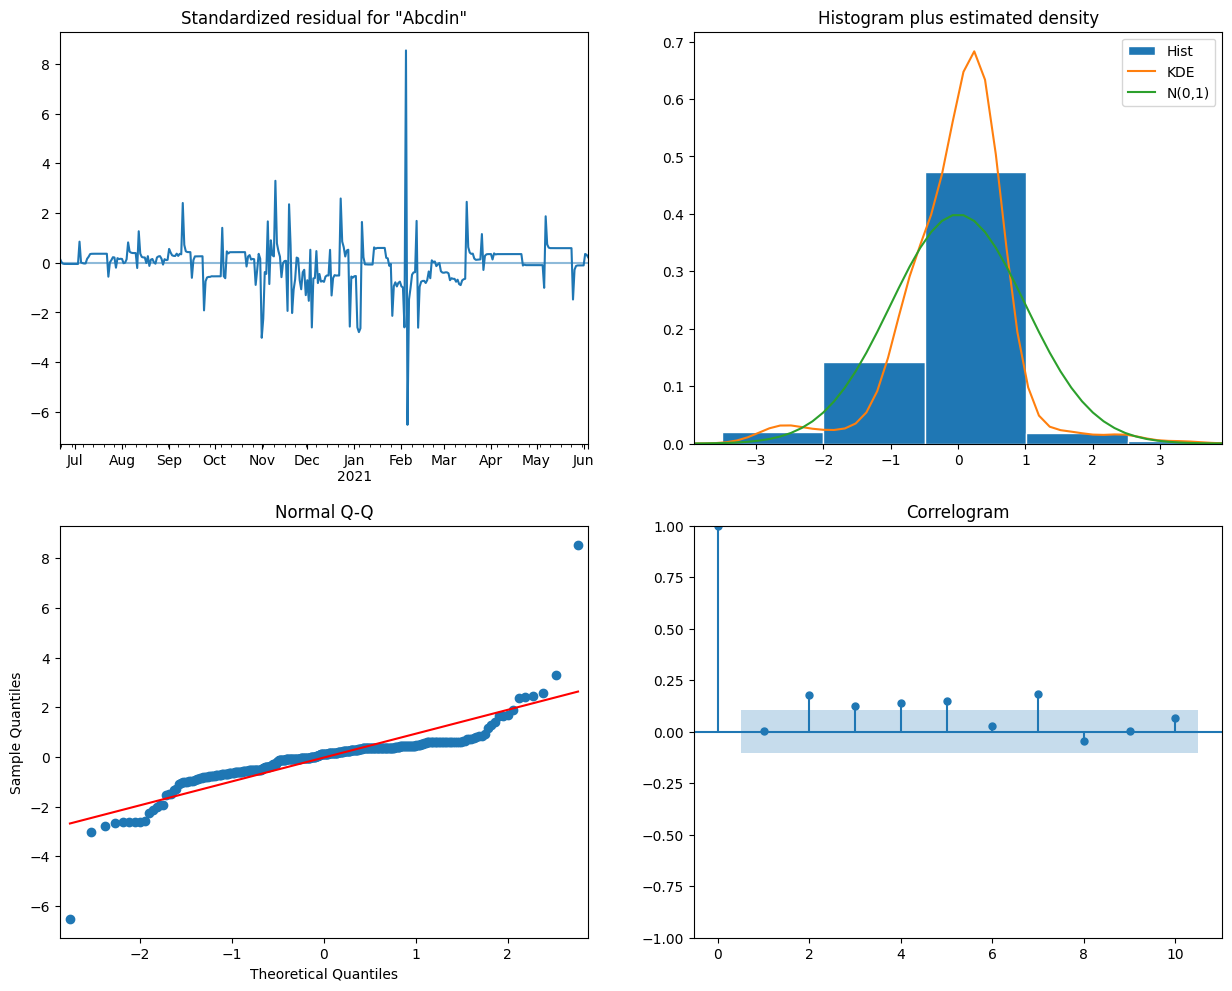

In [11]:
best_model = VARMAX(df_wide[:train_size], order=best_order, enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=-1)
best_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [12]:
## Use the model to predict the next values in the time series

# Here we construct a more complete results object.
NN = len(df_wide[company]) - train_size
print(f"Forcast on {NN} next values")
print(best_model.forecast(steps=NN))
fcast = best_model.get_forecast(steps=NN)

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 95%
print("Statistics of confidence intervals")
fcast.summary_frame(endog=4, alpha=0.05) 

Forcast on 158 next values
                Abcdin   Falabella       Lider       Paris      Ripley  \
2021-06-05  198.053639  213.545504  208.970061  202.357211  203.123519   
2021-06-06  197.527224  216.597310  208.790687  200.250750  205.456670   
2021-06-07  197.536227  218.406100  208.768202  198.908069  207.214532   
2021-06-08  197.832860  219.556946  208.862885  198.075266  208.557739   
2021-06-09  198.268800  220.382085  209.043769  197.586464  209.597663   
...                ...         ...         ...         ...         ...   
2021-11-05  206.138309  248.627134  214.609684  205.468554  216.330613   
2021-11-06  206.139863  248.633885  214.609197  205.470718  216.331966   
2021-11-07  206.141369  248.640420  214.608718  205.472816  216.333280   
2021-11-08  206.142829  248.646744  214.608248  205.474850  216.334557   
2021-11-09  206.144244  248.652865  214.607785  205.476821  216.335796   

                 claro       entel    movistar         wom  
2021-06-05  218.104029 

Ripley,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-06-05,203.123519,10.173817,183.183205,223.063833
2021-06-06,205.456670,13.348395,179.294298,231.619043
2021-06-07,207.214532,14.980846,177.852613,236.576451
2021-06-08,208.557739,15.956465,177.283642,239.831836
2021-06-09,209.597663,16.594166,177.073696,242.121630
...,...,...,...,...
2021-11-05,216.330613,21.041147,175.090721,257.570504
2021-11-06,216.331966,21.041657,175.091076,257.572856
2021-11-07,216.333280,21.042148,175.091427,257.575133
2021-11-08,216.334557,21.042622,175.091775,257.577339



Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             10.7343
Mean Squared Error (MSE)             152.092
Root Mean Squared Error (RMSE)        12.3325
Root Mean Squared Log Error (RMSLE)    2.5122
R Squared (R2)                        -0.3086
Adjusted R Squared (AR2)              -0.3828


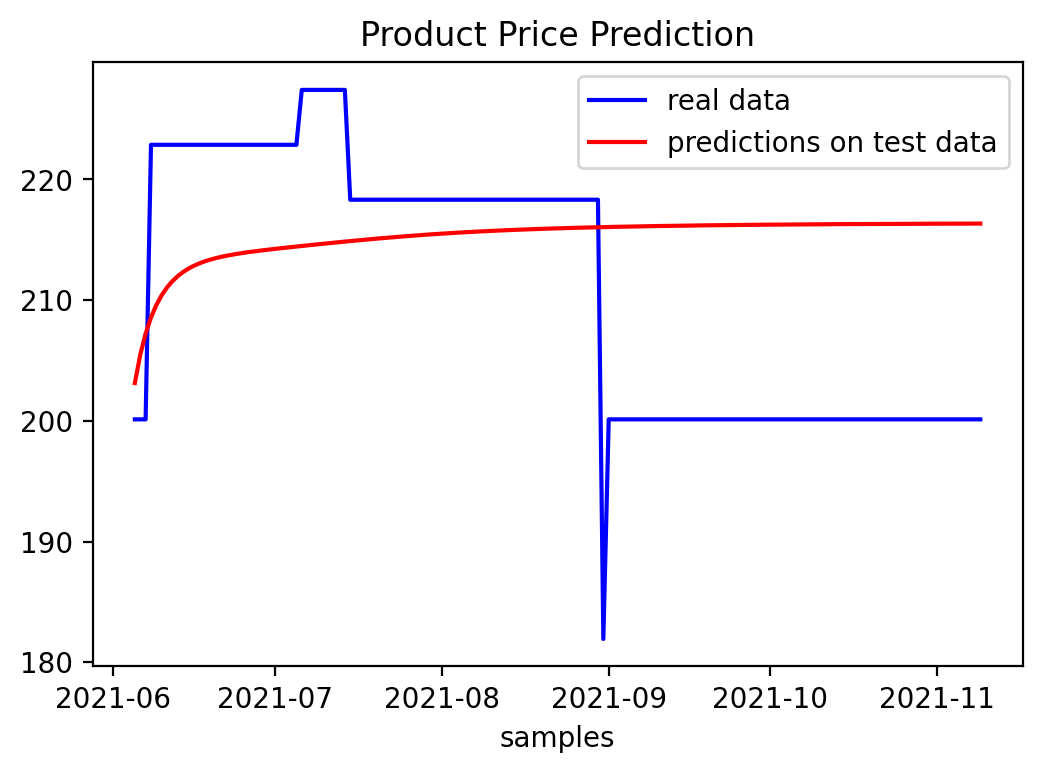

In [13]:
# evaluate the model predictions
y_pred = best_model.forecast(steps=NN)[company]
metrics = evaluate_pred(y_pred, df_wide[company][train_size:])
metrics.insert(0, "VARMA")
multivariate_results.append(metrics)

## Vanilla LSTM

In [18]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_companies)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                12000     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________________________


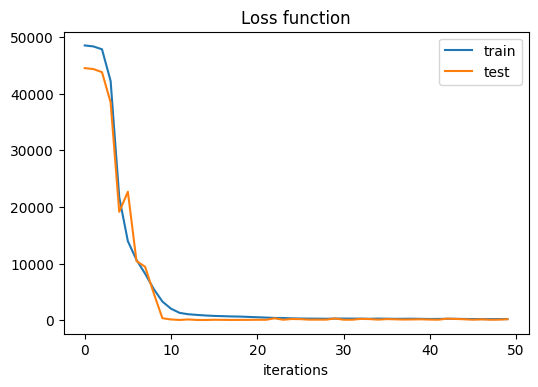

In [19]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)             10.3743
Mean Squared Error (MSE)             172.56
Root Mean Squared Error (RMSE)        13.1362
Root Mean Squared Log Error (RMSLE)    2.5754
R Squared (R2)                        -0.4962
Adjusted R Squared (AR2)              -0.581


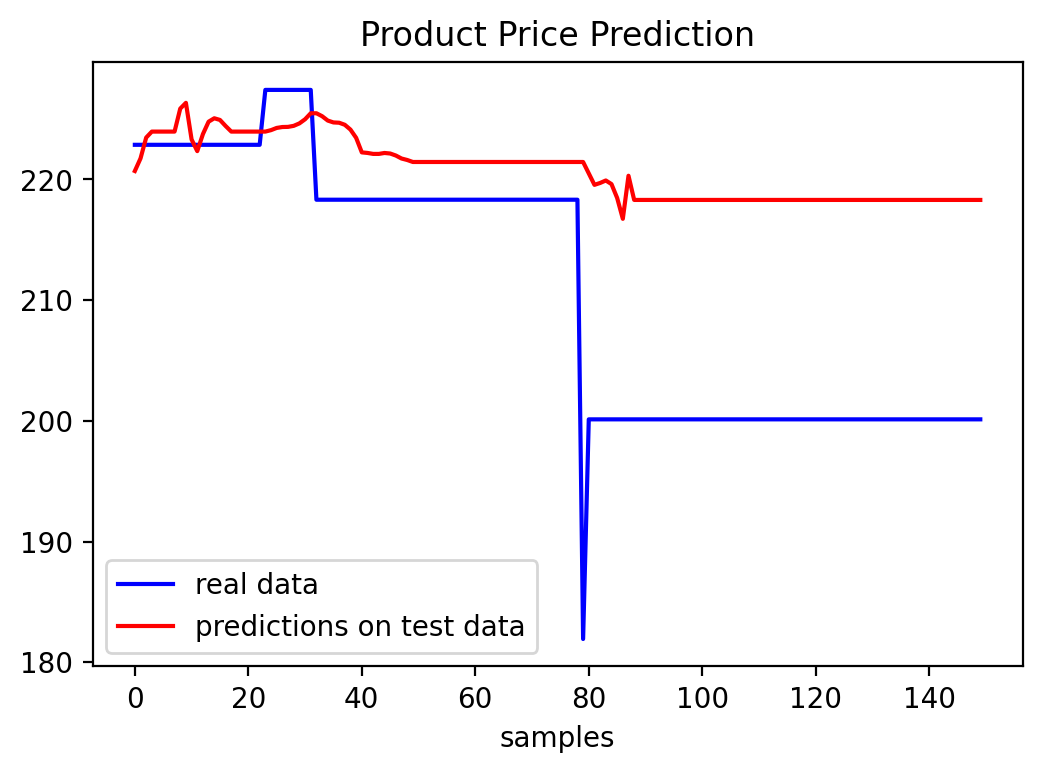

In [20]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Vanilla LSTM")
multivariate_results.append(metrics)

## Stacked LSTM

In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_companies)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8, 50)             12000     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________


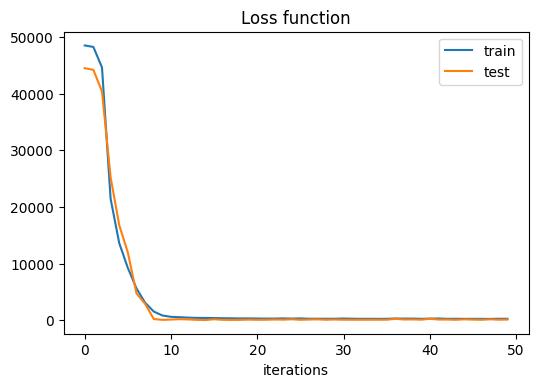

In [22]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                  Value
-----------------------------------  --------
Mean Absolute Error (MAE)              7.8533
Mean Squared Error (MSE)             113.895
Root Mean Squared Error (RMSE)        10.6722
Root Mean Squared Log Error (RMSLE)    2.3676
R Squared (R2)                         0.0125
Adjusted R Squared (AR2)              -0.0435


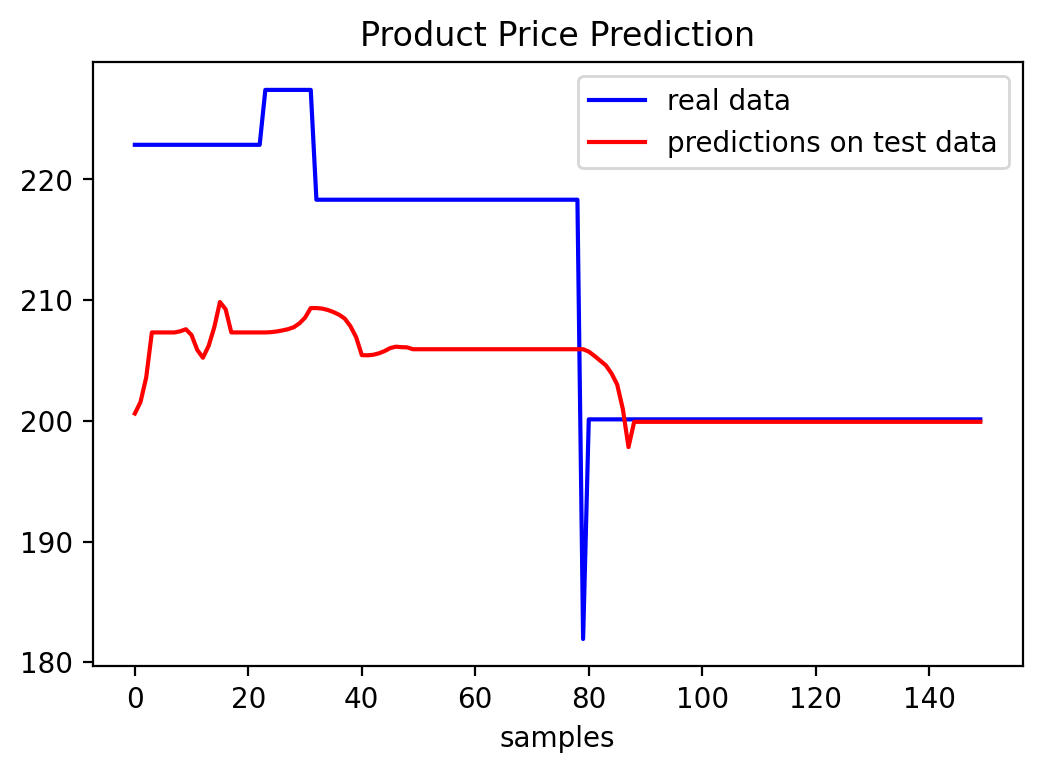

In [23]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Stacked LSTM")
multivariate_results.append(metrics)

## Bidirectional LSTM

In [24]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_companies)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

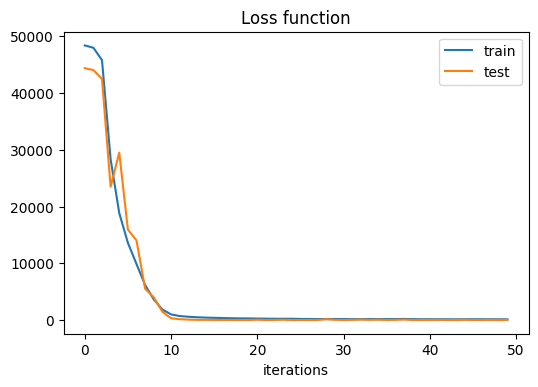

In [25]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             5.1662
Mean Squared Error (MSE)             38.1857
Root Mean Squared Error (RMSE)        6.1795
Root Mean Squared Log Error (RMSLE)   1.8212
R Squared (R2)                        0.6689
Adjusted R Squared (AR2)              0.6501


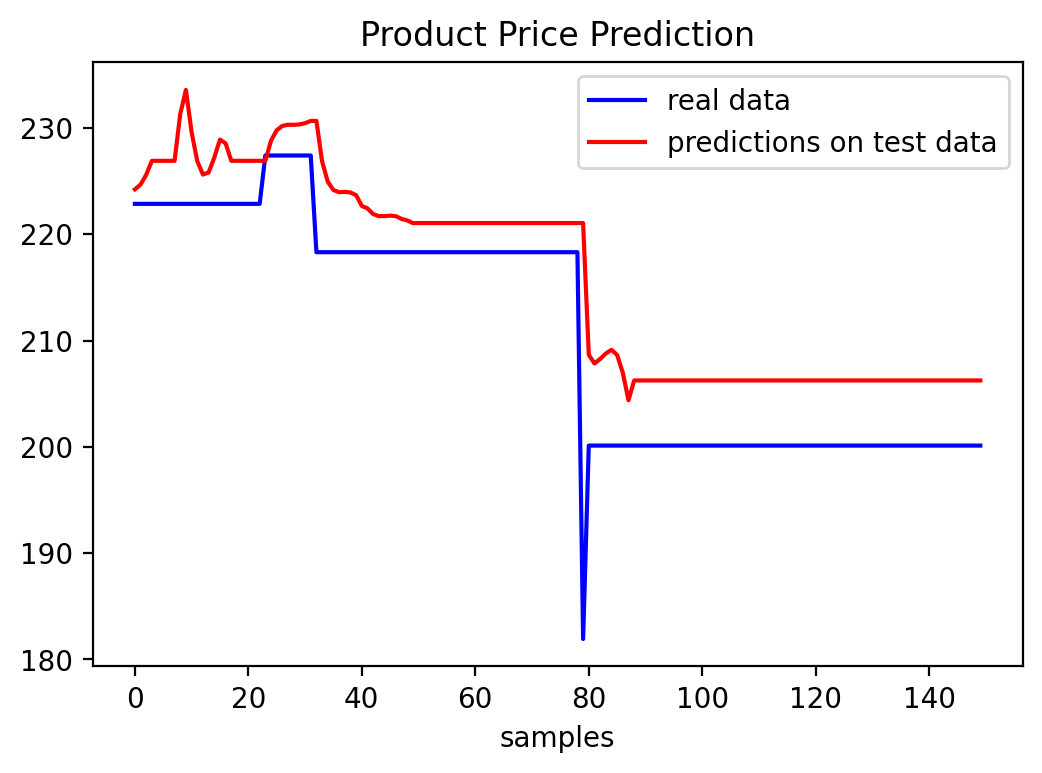

In [26]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "Bidirectional LSTM")
multivariate_results.append(metrics)

## CNN LSTM

In [27]:
# reshape from [samples, timesteps, companies] into [samples, subsequences, timesteps, companies]
n_seq = 2
n_sub_steps = 4
X_train = X_train.reshape((X_train.shape[0], n_seq, n_sub_steps, n_companies))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_sub_steps, n_companies))
print(X_train.shape)
print(X_test.shape)


(349, 2, 4, 9)
(150, 2, 4, 9)


In [28]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_sub_steps, n_companies)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

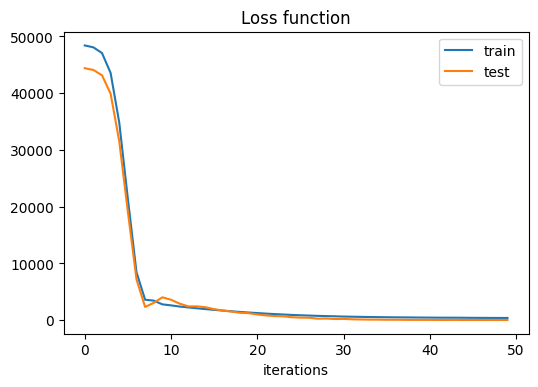

In [29]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             4.3429
Mean Squared Error (MSE)             36.7278
Root Mean Squared Error (RMSE)        6.0603
Root Mean Squared Log Error (RMSLE)   1.8018
R Squared (R2)                        0.6816
Adjusted R Squared (AR2)              0.6772


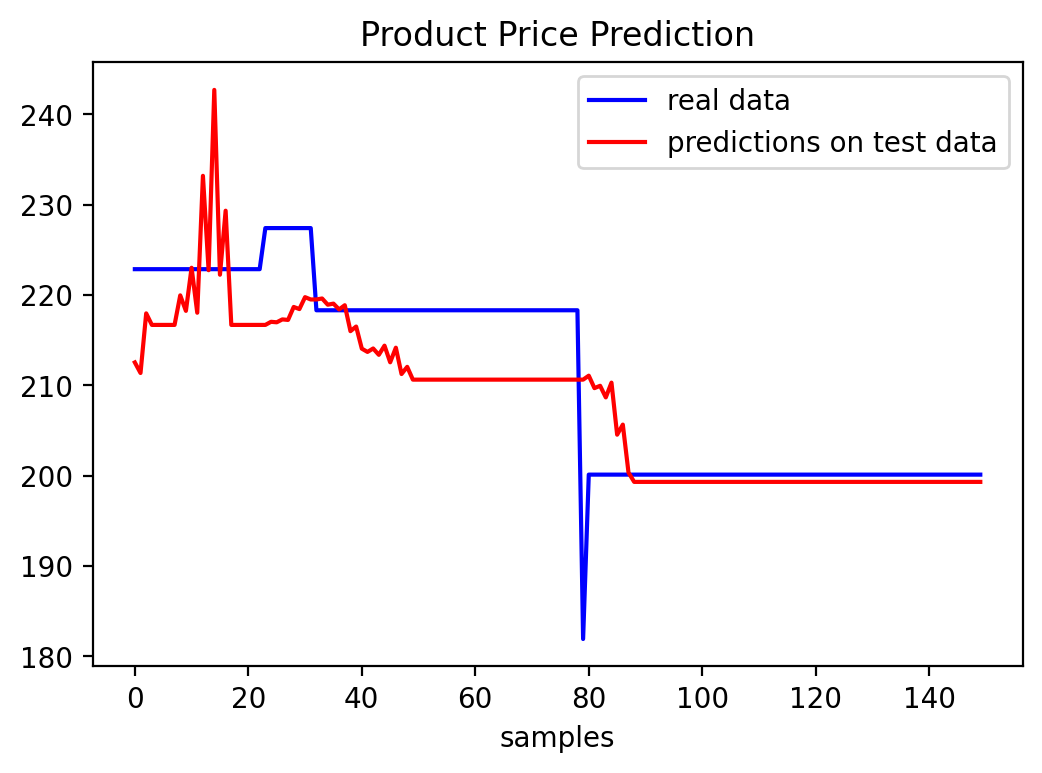

In [30]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "CNN LSTM")
multivariate_results.append(metrics)

## ConvLSTM

In [31]:
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_sub_steps, n_companies))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_sub_steps, n_companies))
print(X_train.shape)
print(X_test.shape)

(349, 2, 1, 4, 9)
(150, 2, 1, 4, 9)


In [32]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_sub_steps, n_companies)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

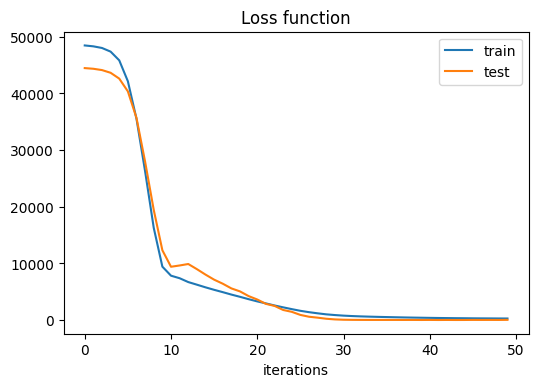

In [33]:
# fit the model with the training data and
# get its' price predictions on the test data
y_pred = train_and_test_model(model)


Metric                                 Value
-----------------------------------  -------
Mean Absolute Error (MAE)             5.7321
Mean Squared Error (MSE)             51.5943
Root Mean Squared Error (RMSE)        7.1829
Root Mean Squared Log Error (RMSLE)   1.9717
R Squared (R2)                        0.5527
Adjusted R Squared (AR2)              0.5466


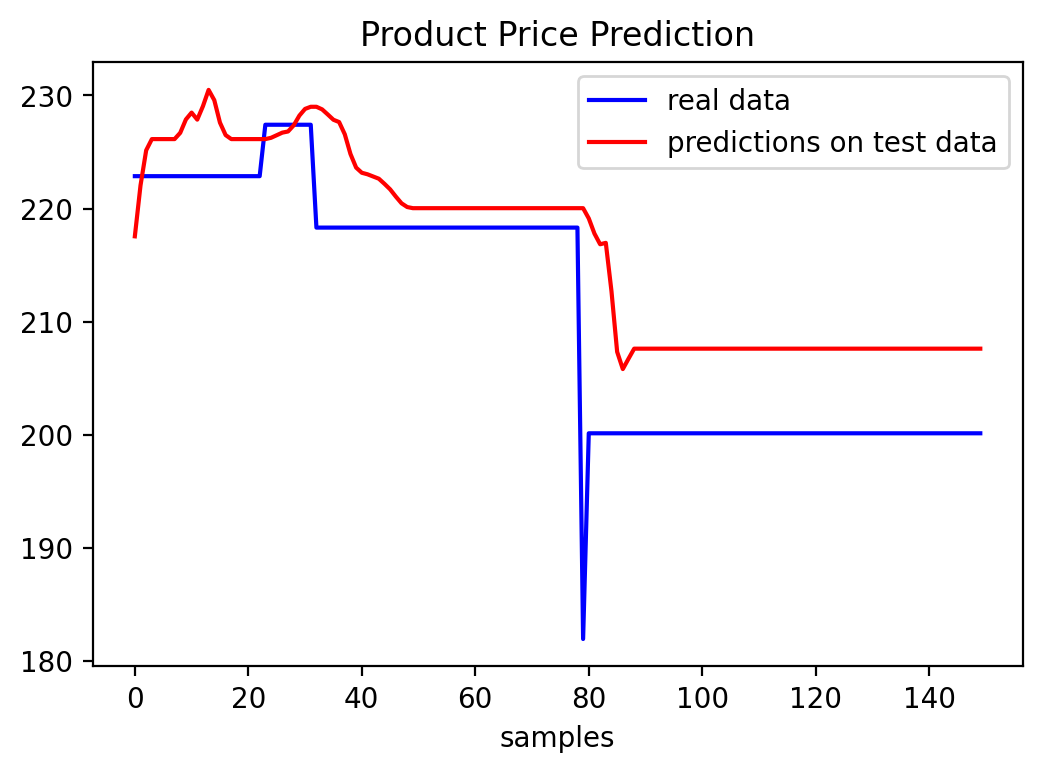

In [34]:
# evaluate the model predictions
metrics = evaluate_pred(y_pred, y_test)
metrics.insert(0, "ConvLSTM")
multivariate_results.append(metrics)

## Models Results

In [35]:
print(tabulate(multivariate_results,
               headers=["Multivariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='latex_booktabs'
               ))

tabulate(multivariate_results,
         headers=["Multivariate Model", "MAE", "MSE", "RMSE", "RMSLE", "R2", "AR2"], tablefmt='html'
         )


\begin{tabular}{lrrrrrr}
\toprule
 Multivariate Model   &     MAE &      MSE &    RMSE &   RMSLE &      R2 &     AR2 \\
\midrule
 VARMA                & 10.7343 & 152.092  & 12.3325 &  2.5122 & -0.3086 & -0.3828 \\
 Vanilla LSTM         & 10.3743 & 172.56   & 13.1362 &  2.5754 & -0.4962 & -0.581  \\
 Stacked LSTM         &  7.8533 & 113.895  & 10.6722 &  2.3676 &  0.0125 & -0.0435 \\
 Bidirectional LSTM   &  5.1662 &  38.1857 &  6.1795 &  1.8212 &  0.6689 &  0.6501 \\
 CNN LSTM             &  4.3429 &  36.7278 &  6.0603 &  1.8018 &  0.6816 &  0.6772 \\
 ConvLSTM             &  5.7321 &  51.5943 &  7.1829 &  1.9717 &  0.5527 &  0.5466 \\
\bottomrule
\end{tabular}


Multivariate Model,MAE,MSE,RMSE,RMSLE,R2,AR2
VARMA,10.7343,152.092,12.3325,2.5122,-0.3086,-0.3828
Vanilla LSTM,10.3743,172.56,13.1362,2.5754,-0.4962,-0.581
Stacked LSTM,7.8533,113.895,10.6722,2.3676,0.0125,-0.0435
Bidirectional LSTM,5.1662,38.1857,6.1795,1.8212,0.6689,0.6501
CNN LSTM,4.3429,36.7278,6.0603,1.8018,0.6816,0.6772
ConvLSTM,5.7321,51.5943,7.1829,1.9717,0.5527,0.5466
